In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import matplotlib as mpl
import scipy.stats
import matplotlib.patches as mpatches


In [2]:
final_results = pd.read_csv('final_results.csv', index_col=0)

Plot average and error

In [3]:
# fig, ax = plt.subplots()
# ax.set_ylabel('Dice score')
# ax.set_title('Dice score for different models')
# ax.set_xticks(labels=final_results.index,
#               ticks=range(len(final_results.index)), 
#               rotation=90)
# ax.bar(x=final_results.index, height=final_results.mean(axis=1),  yerr=final_results.std(axis=1))
# plt.show()

In [4]:
def plot_bar(ax: plt.Axes, data: pd.DataFrame, color=None, hatches=None, ys=None):
    # Check if hatches is None. If it is, set it to an empty list
    if hatches is None:
        hatches = [''] * len(data)

    if ys is None:
        ys = list(data.index)

    for i, hatch in enumerate(hatches):
        ax.barh(
            y=ys[i],
            width=data.mean(axis=1).iloc[i], 
            height=0.8, 
            color=color,
            
            xerr=data.std(axis=1).iloc[i], 
            capsize=4,
            ecolor=color,
            
            hatch=hatch,
            edgecolor='white',

            zorder=3
            )

def get_statistical_label(pval: float, max_num_stars=3, show_raw_values=False) -> str:
    # * is p < 0.05
    # ** is p < 0.005
    # *** is p < 0.0005
    # etc.
    if show_raw_values:
        text = f'p={pval:.3f}'
        return text
    text = ''
    p = .05
    while pval < p:
        text += '*'
        p /= 10.
        if len(text) == max_num_stars:
            break

    if len(text) == 0:
        text = 'n. s.'

    return text

def plot_statistical_significance(data_index1: int, data_index2: int, min_y: float, max_y: float, full_data: pd.DataFrame, ax: plt.Axes, min_x_offset: float = 0.005, alternative: str = 'one-sided', show_raw_values: bool = False):
    if alternative == 'one-sided':
        _, pval1 = scipy.stats.ttest_rel(full_data.iloc[data_index1, :], full_data.iloc[data_index2, :], alternative='less') # one-sided t-test
        _, pval2 = scipy.stats.ttest_rel(full_data.iloc[data_index1, :], full_data.iloc[data_index2, :], alternative='greater') # one-sided t-test
        pval = min(pval1, pval2)
    else:
        _, pval = scipy.stats.ttest_rel(full_data.iloc[data_index1, :], full_data.iloc[data_index2, :], alternative=alternative)
    text = get_statistical_label(pval, show_raw_values=show_raw_values)

    min_x = full_data.iloc[:2, :].mean(axis=1).max() + full_data.iloc[:2, :].std(axis=1).max() + .005 + min_x_offset
    max_x = min_x + 0.005
    ax.plot([min_x, max_x, max_x, min_x], [min_y, min_y, max_y, max_y], color='black')
    ax.text(max_x + 0.005, (min_y + max_y) / 2, text, va='center', rotation=-90)

def get_y_positions(group: list) -> list:
    y_pos = []
    current_group = group[0]
    current_position = -0.8

    for g in group:
        if g != current_group:
            current_group = g
            current_position += 0.8*2
        else:
            current_position += 0.8
        y_pos.append(current_position)
    return y_pos

def get_color_list(group: list, cmap: mpl.colors.ListedColormap) -> list:
    color_list = []
    group_step = cmap.N // len(set(group))
    from collections import Counter
    counter = Counter(group)
    for i, g in enumerate(set(group)):
        step = group_step // counter[g] // 2
        for j in range(counter[g]):
            color_list.append(cmap(group_step * i + step * j))
    return color_list

def plot_data_values(data: pd.DataFrame, ax: plt.Axes, y_positions: list, show_err=False, y_offset=0.05, x_offset=0.01, color='white', backgroundcolor='none'):
    # Plot the mean and standard deviation on the bars
    for i in range(len(data)):
        mean = data.iloc[i, :].mean()
        std = data.iloc[i, :].std()
        s = f'{mean:.3f}' if not show_err else f'{mean:.3f}±{std:.3f}'
        # f'{mean:.3f}±{std:.3f}'
        ax.text(x=mean - x_offset, y=y_positions[i] - y_offset,  s=s, color=color, va='center', ha='right', zorder=4,
                backgroundcolor=backgroundcolor)

nnUNet results only

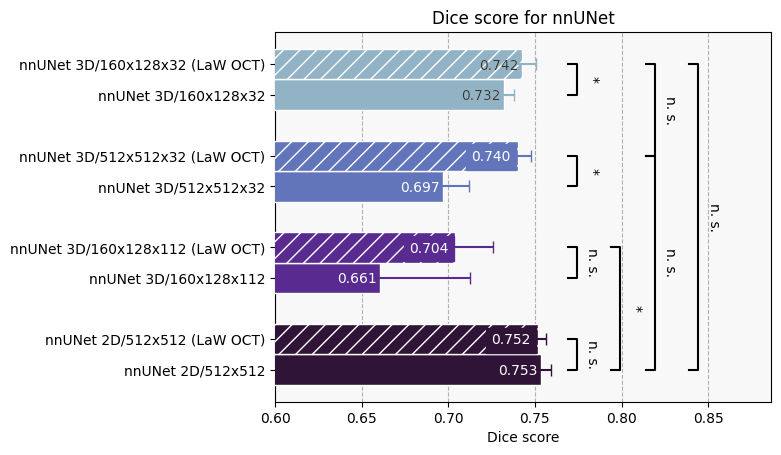

In [5]:
cmap = mpl.colormaps['Set1']
cmap = mpl.colormaps['twilight_shifted']

nnunet_results = final_results.iloc[[0,1,  2,3,  5,6,  7,8], :3]

fig, ax = plt.subplots()
ax.set_xlabel('Dice score')
ax.set_title('Dice score for nnUNet')

step = cmap.N // nnunet_results.shape[0]

group = [0,0, 1,1, 2,2, 3,3]
y_positions = get_y_positions(group)

# 2D nnUNet
plot_bar(ax, nnunet_results.iloc[:2, :], cmap(0), ['', '//'], ys=y_positions[0:2]) # 2D nnUNet
plot_statistical_significance(0, 1, y_positions[0], y_positions[1], nnunet_results, ax)

plot_bar(ax, nnunet_results.iloc[2:4, :], cmap(step * 1), ['', '//'], ys=y_positions[2:4]) # 3D nnUNet 160x128x112
plot_statistical_significance(2, 3, y_positions[2], y_positions[3], nnunet_results, ax)

plot_bar(ax, nnunet_results.iloc[4:6, :], cmap(step * 2), ['', '//'], y_positions[4:6]) # 3D nnUNet 512x512x32
plot_statistical_significance(4, 5, y_positions[4], y_positions[5], nnunet_results, ax)

plot_bar(ax, nnunet_results.iloc[6:8, :], cmap(step * 3), ['', '//'], y_positions[6:8]) # 3D nnUNet 160x128x32
plot_statistical_significance(6, 7, y_positions[6], y_positions[7], nnunet_results, ax)

ax.set_yticks(y_positions, labels=nnunet_results.index)

plot_statistical_significance(0, 3, y_positions[0], y_positions[3], nnunet_results, ax, min_x_offset=0.03)
plot_statistical_significance(0, 5, y_positions[0], y_positions[5], nnunet_results, ax, min_x_offset=0.05)
plot_statistical_significance(0, 7, y_positions[0], y_positions[7], nnunet_results, ax, min_x_offset=0.075)
plot_statistical_significance(5, 7, y_positions[5], y_positions[7], nnunet_results, ax, min_x_offset=0.05)

plot_data_values(nnunet_results, ax, y_positions, x_offset=0.002, y_offset=0.03)

special_data_color_indices = [6 ,7]
plot_data_values(nnunet_results.iloc[special_data_color_indices, :], ax, [y_positions[p] for p in special_data_color_indices], x_offset=0.002, y_offset=0.03, color=(0.2,)*3)

special_data_color_indices = [1, 3, 5]
colors = [cmap(0), cmap(step * 1), cmap(step * 2)]
for i, color in zip(special_data_color_indices, colors):
    plot_data_values(nnunet_results.iloc[[i], :], ax, [y_positions[i]], x_offset=0.004, y_offset=0.03, color='white', backgroundcolor=color)
# plot_data_values(nnunet_results.iloc[special_data_color_indices, :], ax, [y_positions[p] for p in special_data_color_indices], x_offset=0.004, y_offset=0.03, color='white', backgroundcolor=(0.3,)*3)



ax.set_xlim(0.6)
ax.grid(zorder=-1, axis='x', linestyle='--')
ax.set_facecolor((0.9725,) * 3)
fig.patch.set_alpha(0.0) # outside of the plot
fig.savefig('result_nnunet_results.png', dpi=1000, bbox_inches='tight')
plt.show()

SuPreM results only

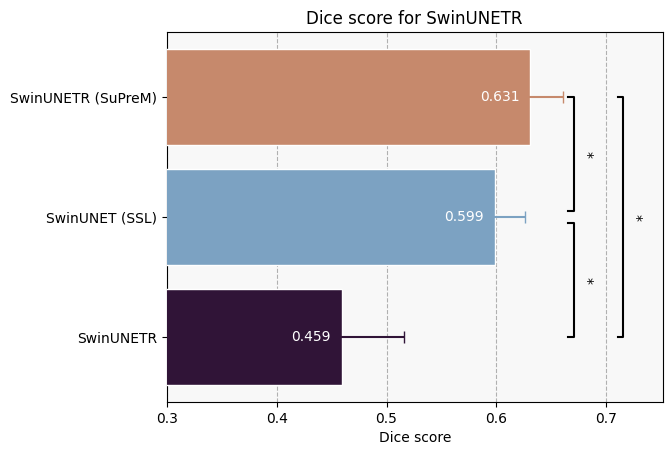

In [6]:
suprem_results = final_results.iloc[10:13, :3]

fig, ax = plt.subplots()
ax.set_xlabel('Dice score')
ax.set_title('Dice score for SwinUNETR')

step = cmap.N // suprem_results.shape[0]

plot_bar(ax, suprem_results.iloc[0:1, :], cmap(0)) # SwinUNETR
plot_bar(ax, suprem_results.iloc[1:2, :], cmap(step * 1)) # SwinUNETR (SSL)
plot_bar(ax, suprem_results.iloc[2:3, :], cmap(step * 2)) # SwinUNETR (SuPreM)

plot_statistical_significance(0, 1, 0, 1 -.05, suprem_results, ax)
plot_statistical_significance(1, 2, 1 +.05, 2, suprem_results, ax)
plot_statistical_significance(0, 2, 0, 2, suprem_results, ax, min_x_offset=0.05)

plot_data_values(suprem_results, ax, [0, 1, 2], show_err=False, y_offset=0.0)

ax.set_xlim(0.3)
ax.grid(zorder=-1, axis='x', linestyle='--')
ax.set_facecolor((0.9725,) * 3)
fig.patch.set_alpha(0.0) # outside of the plot
fig.savefig('result_SwinUNETR_results.png', dpi=1000, bbox_inches='tight')
plt.show()

SegFormer vs Best nnUNet

In [7]:
nnunet_and_transformer_results = pd.concat([final_results.iloc[[0, 8], :3], final_results.iloc[12:15, :3]])
nnunet_and_transformer_results


,fold0,fold1,fold2
nnUNet 2D/512x512,0.746711,0.758020,0.755058
nnUNet 3D/160x128x32 (LaW OCT),0.749061,0.733704,0.744661
SwinUNETR (SuPreM),0.604358,0.625184,0.662903
ViT+BNLinear (RADIO),0.543160,0.558163,0.526754
SegFormer (ADE60K),0.692117,0.690565,0.679500


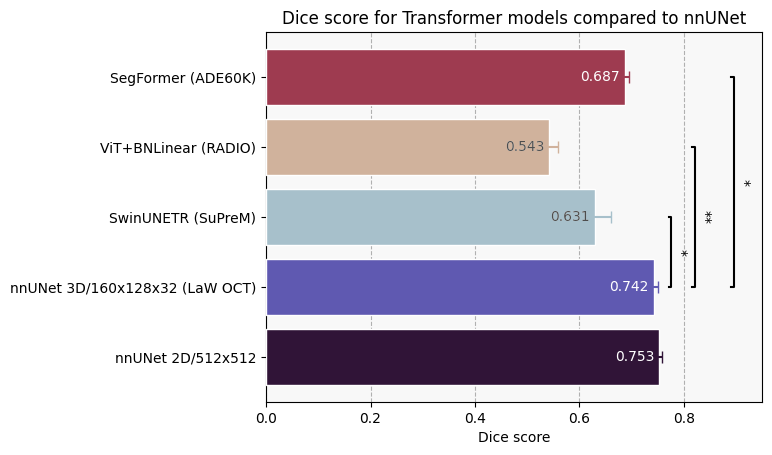

In [8]:
fig, ax = plt.subplots()

ax.set_xlabel('Dice score')
ax.set_title('Dice score for Transformer models compared to nnUNet')

step = cmap.N // nnunet_and_transformer_results.shape[0]

plot_bar(ax, nnunet_and_transformer_results.iloc[0:1, :], cmap(step * 0)) # 2D nnUNet
plot_bar(ax, nnunet_and_transformer_results.iloc[1:2, :], cmap(step * 1)) # 3D nnUNet 160x128x32
plot_bar(ax, nnunet_and_transformer_results.iloc[2:3, :], cmap(step * 2)) # SwinUNETR (SuPreM)
plot_bar(ax, nnunet_and_transformer_results.iloc[3:4, :], cmap(step * 3)) # SwinUNETR (SuPreM)
plot_bar(ax, nnunet_and_transformer_results.iloc[4:5, :], cmap(step * 4)) # SwinUNETR (SuPreM)

plot_statistical_significance(2, 1, 1, 2, nnunet_and_transformer_results, ax)
plot_statistical_significance(3, 1, 1, 3, nnunet_and_transformer_results, ax, min_x_offset=0.05)
plot_statistical_significance(4, 1, 1, 4, nnunet_and_transformer_results, ax, min_x_offset=0.125)

plot_data_values(nnunet_and_transformer_results, ax, range(len(nnunet_and_transformer_results)), y_offset=0)
plot_data_values(nnunet_and_transformer_results.iloc[2:4, :], ax, [2, 3], y_offset=0, color=(0.3,)*3)

ax.set_xlim(0, 0.95)
ax.grid(zorder=-1, axis='x', linestyle='--')
ax.set_facecolor((0.9725,) * 3)
fig.patch.set_alpha(0.0) # outside of the plot
fig.savefig('result_nnUNet_vs_Transformer_results.png', dpi=1000, bbox_inches='tight')
plt.show()

V-JEPA

In [9]:
vjepa_results = final_results.iloc[15:, :3]
vjepa_results

,fold0,fold1,fold2
ViT+BNLinear (V-JEPA VideoMix2M),0.672462,0.633231,0.653126
ViT+Multifeat (V-JEPA VideoMix2M),0.616627,0.707579,0.659973
ViT+Attentive(V-JEPA VideoMix2M),0.644050,0.692062,0.648973
ViT+Attentive* (V-JEPA VideoMix2M),0.647917,0.708620,0.660258
ViT+Attentive* (V-JEPA Unannotated OCT),0.315492,0.309449,0.336110
ViT+Attentive*,0.337566,0.293981,0.315984


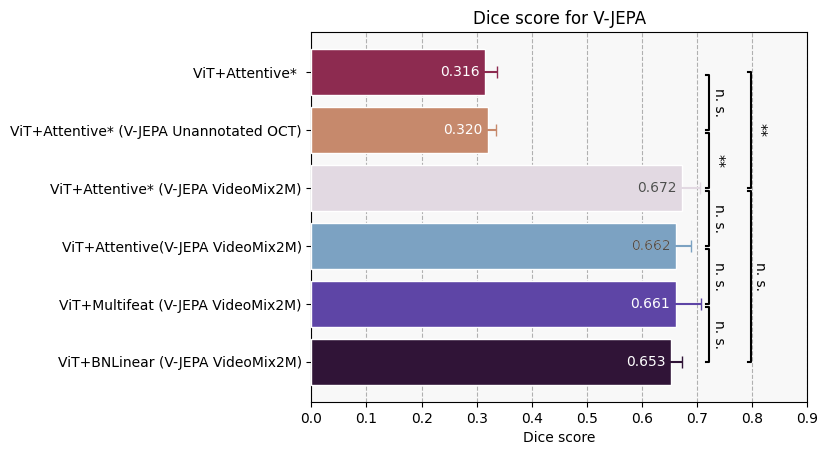

In [10]:
fig, ax = plt.subplots()
ax.set_xlabel('Dice score')
ax.set_title('Dice score for V-JEPA')

step = cmap.N // vjepa_results.shape[0]

for i in range(len(vjepa_results)):
    color = cmap(step * i)
    plot_bar(ax, vjepa_results.iloc[i:i+1, :], color)

for i in range(len(vjepa_results) - 1):
    plot_statistical_significance(i+1, i, i, i + 1 - .05, vjepa_results, ax)

plot_statistical_significance(0, 3, 0, 2.95, vjepa_results, ax, min_x_offset=0.08)
plot_statistical_significance(5, 3, 3, 5, vjepa_results, ax, min_x_offset=0.08)

plot_data_values(vjepa_results, ax, range(len(vjepa_results)), y_offset=0)
plot_data_values(vjepa_results.iloc[2:4, :], ax, [2, 3], y_offset=0, color=(0.3,) * 3)

ax.set_xlim(0, 0.9)
ax.grid(zorder=-1, axis='x', linestyle='--')
ax.set_facecolor((0.9725,) * 3)
fig.patch.set_alpha(0.0) # outside of the plot
fig.savefig('result_VJEPA_results.png', dpi=1000, bbox_inches='tight')
plt.show()

In [11]:
nnunet_and_vjepa_results = pd.concat([final_results.iloc[[0, 8], :3], final_results.iloc[[18, 19], :3]])
nnunet_and_vjepa_results

,fold0,fold1,fold2
nnUNet 2D/512x512,0.746711,0.758020,0.755058
nnUNet 3D/160x128x32 (LaW OCT),0.749061,0.733704,0.744661
ViT+Attentive* (V-JEPA VideoMix2M),0.647917,0.708620,0.660258
ViT+Attentive* (V-JEPA Unannotated OCT),0.315492,0.309449,0.336110


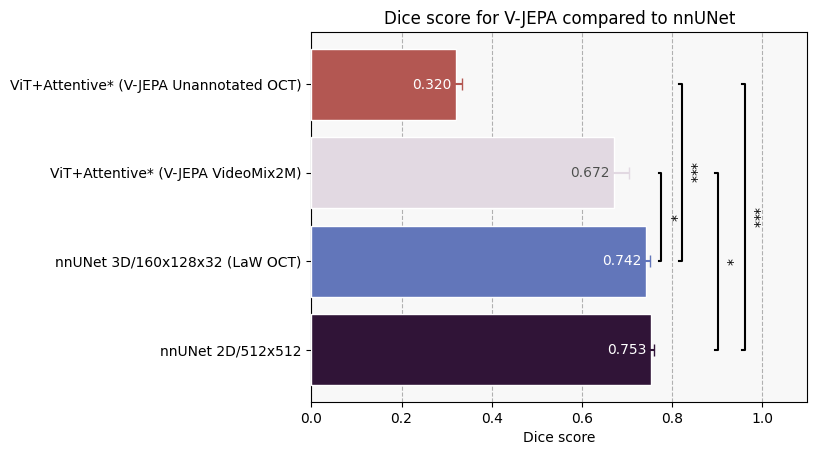

In [12]:
fig, ax = plt.subplots()
ax.set_xlabel('Dice score')
ax.set_title('Dice score for V-JEPA compared to nnUNet')

step = cmap.N // nnunet_and_vjepa_results.shape[0]
for i in range(len(nnunet_and_vjepa_results)):
    color = cmap(step * i)
    plot_bar(ax, nnunet_and_vjepa_results.iloc[i:i+1, :], color)

plot_statistical_significance(1, 2, 1, 2, nnunet_and_vjepa_results, ax)
plot_statistical_significance(1, 3, 1, 3, nnunet_and_vjepa_results, ax, min_x_offset=0.05)

plot_statistical_significance(0, 2, 0, 2, nnunet_and_vjepa_results, ax, min_x_offset=0.13)
plot_statistical_significance(0, 3, 0, 3, nnunet_and_vjepa_results, ax, min_x_offset=0.19)

plot_data_values(nnunet_and_vjepa_results, ax, [0, 1, 2, 3], y_offset=0)
plot_data_values(nnunet_and_vjepa_results.iloc[2:3, :], ax, [2], y_offset=0, color=(0.3,) * 3)

ax.set_xlim(0, 1.1)
ax.grid(zorder=-1, axis='x', linestyle='--')
ax.set_facecolor((0.9725,) * 3)
fig.patch.set_alpha(0.0) # outside of the plot
fig.savefig('result_nnUNet_and_VJEPA_results.png', dpi=1000, bbox_inches='tight')
plt.show()

Genesis

In [13]:
nnunet_and_genesis = final_results.iloc[[0, 7, 8 ,4], :3]
nnunet_and_genesis

,fold0,fold1,fold2
nnUNet 2D/512x512,0.746711,0.758020,0.755058
nnUNet 3D/160x128x32,0.734188,0.725896,0.736379
nnUNet 3D/160x128x32 (LaW OCT),0.749061,0.733704,0.744661
nnUNet 3D/160x128x32 (Genesis Unannotated OCT),0.743755,0.743732,0.743380


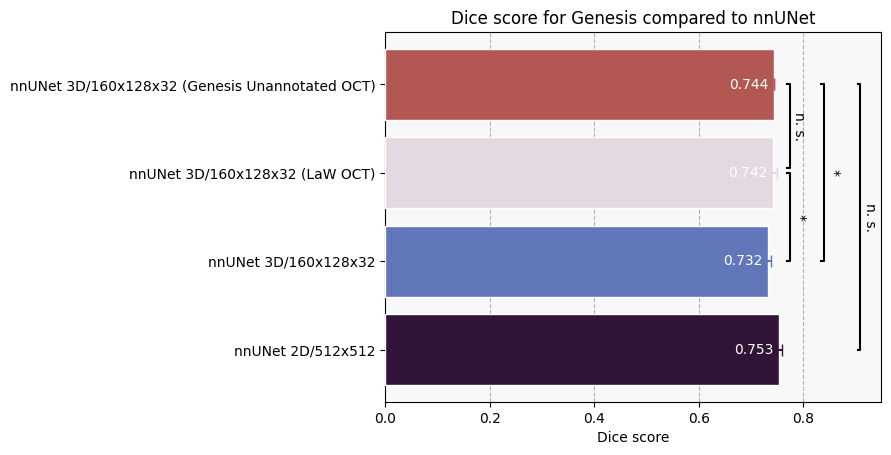

In [14]:
fig, ax = plt.subplots()
ax.set_xlabel('Dice score')
ax.set_title('Dice score for Genesis compared to nnUNet')

step = cmap.N // nnunet_and_genesis.shape[0]
for i in range(len(nnunet_and_genesis)):
    color = cmap(step * i)
    plot_bar(ax, nnunet_and_genesis.iloc[i:i+1, :], color)

plot_statistical_significance(1, 2, 1, 2, nnunet_and_genesis, ax)
plot_statistical_significance(1, 3, 1, 3, nnunet_and_genesis, ax, min_x_offset=0.07)
plot_statistical_significance(2, 3, 2+.05, 3, nnunet_and_genesis, ax, alternative='two-sided')
plot_statistical_significance(0, 3, 0, 3, nnunet_and_genesis, ax, min_x_offset=0.14, alternative='two-sided')

plot_data_values(nnunet_and_genesis, ax, range(len(nnunet_and_genesis)), show_err=False, y_offset=0.0)

ax.set_xlim(0, .95)
ax.grid(zorder=-1, axis='x', linestyle='--')
ax.set_facecolor((0.9725,) * 3)
fig.patch.set_alpha(0.0) # outside of the plot
fig.savefig('result_nnUNet_and_Genesis_results.png', dpi=1000, bbox_inches='tight')
plt.show()

CLIP and nnUNet

In [15]:
nnunet_and_CLIP_results = pd.concat([final_results.iloc[[0, 7, 8], :3], final_results.iloc[[9], :3]])
nnunet_and_CLIP_results

,fold0,fold1,fold2
nnUNet 2D/512x512,0.746711,0.758020,0.755058
nnUNet 3D/160x128x32,0.734188,0.725896,0.736379
nnUNet 3D/160x128x32 (LaW OCT),0.749061,0.733704,0.744661
nnUNet 3D/160x128x32 (CLIP Pre-&Post-IVL),0.751775,0.731285,0.748879


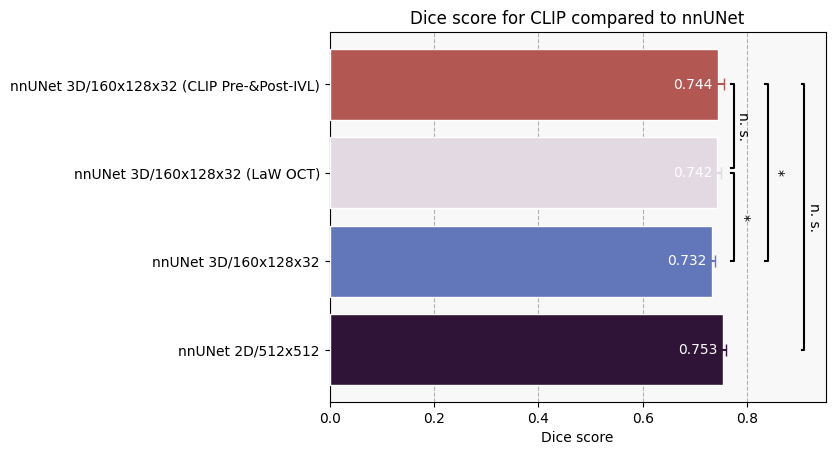

In [16]:
fig, ax = plt.subplots()
ax.set_xlabel('Dice score')
ax.set_title('Dice score for CLIP compared to nnUNet')

step = cmap.N // nnunet_and_CLIP_results.shape[0]
for i in range(len(nnunet_and_CLIP_results)):
    color = cmap(step * i)
    plot_bar(ax, nnunet_and_CLIP_results.iloc[i:i+1, :], color)

plot_statistical_significance(1, 2, 1, 2, nnunet_and_CLIP_results, ax)
plot_statistical_significance(1, 3, 1, 3, nnunet_and_CLIP_results, ax, min_x_offset=0.07)
plot_statistical_significance(2, 3, 2+.05, 3, nnunet_and_CLIP_results, ax)
plot_statistical_significance(0, 3, 0, 3, nnunet_and_CLIP_results, ax, min_x_offset=0.14)

plot_data_values(nnunet_and_CLIP_results, ax, range(len(nnunet_and_CLIP_results)), show_err=False, y_offset=0.0)

ax.set_xlim(0, .95)
ax.grid(zorder=-1, axis='x', linestyle='--')
ax.set_facecolor((0.9725,) * 3)
fig.patch.set_alpha(0.0) # outside of the plot
fig.savefig('result_nnUNet_and_CLIP_results.png', dpi=1000, bbox_inches='tight')
plt.show()

All best models together

In [17]:
final_results

,fold0,fold1,fold2
nnUNet 2D/512x512,0.746711,0.758020,0.755058
nnUNet 2D/512x512 (LaW OCT),0.748167,0.757290,0.749516
nnUNet 3D/160x128x112,0.669249,0.604900,0.707463
nnUNet 3D/160x128x112 (LaW OCT),0.682218,0.704122,0.725997
nnUNet 3D/160x128x32 (Genesis Unannotated OCT),0.743755,0.743732,0.743380
nnUNet 3D/512x512x32,0.696773,0.681866,0.711797
nnUNet 3D/512x512x32 (LaW OCT),0.742685,0.731061,0.746115
nnUNet 3D/160x128x32,0.734188,0.725896,0.736379
nnUNet 3D/160x128x32 (LaW OCT),0.749061,0.733704,0.744661
nnUNet 3D/160x128x32 (CLIP Pre-&Post-IVL),0.751775,0.731285,0.748879


In [18]:
all_best_results = final_results.iloc[[0, 8, 12, 13, 14, 18, 9, 4, 19], :3]
all_best_results

,fold0,fold1,fold2
nnUNet 2D/512x512,0.746711,0.758020,0.755058
nnUNet 3D/160x128x32 (LaW OCT),0.749061,0.733704,0.744661
SwinUNETR (SuPreM),0.604358,0.625184,0.662903
ViT+BNLinear (RADIO),0.543160,0.558163,0.526754
SegFormer (ADE60K),0.692117,0.690565,0.679500
ViT+Attentive* (V-JEPA VideoMix2M),0.647917,0.708620,0.660258
nnUNet 3D/160x128x32 (CLIP Pre-&Post-IVL),0.751775,0.731285,0.748879
nnUNet 3D/160x128x32 (Genesis Unannotated OCT),0.743755,0.743732,0.743380
ViT+Attentive* (V-JEPA Unannotated OCT),0.315492,0.309449,0.336110


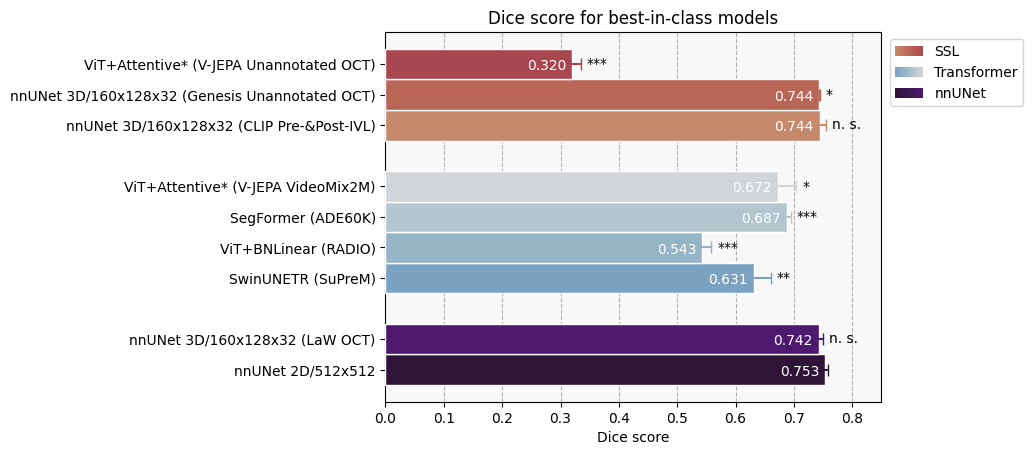

In [19]:
fig, ax = plt.subplots()
ax.set_xlabel('Dice score')
ax.set_title('Dice score for best-in-class models')

step = cmap.N // all_best_results.shape[0]

# Create y positions for the bars based on the group (nnUNet, Transformer, SSL)
group = [0, 0, 1, 1, 1, 1, 2, 2, 2]
y_pos = get_y_positions(group)
color_list = get_color_list(group, cmap)

class Handler(object):
    def __init__(self, color):
        self.color=color
    def legend_artist(self, legend, orig_handle, fontsize, handlebox):
        x0, y0 = handlebox.xdescent, handlebox.ydescent
        width, height = handlebox.width, handlebox.height
        for i in range(256):
            patch = plt.Rectangle([x0 + i * width / 256, y0], width / 256, height, linewidth=0, facecolor=self.color(i), transform=handlebox.get_transform())
            handlebox.add_artist(patch)
        return patch

handles = [plt.Rectangle((0,0),1,1) for i  in range(3)]
colors = [
    mpl.colors.LinearSegmentedColormap.from_list('nnUNet', color_list[:2], N=256),
    mpl.colors.LinearSegmentedColormap.from_list('Transformer', color_list[2:6], N=256),
    mpl.colors.LinearSegmentedColormap.from_list('SSL', color_list[6:], N=256),
][::-1]
legend_labels = ["nnUNet", "Transformer", "SSL"][::-1]
hmap = dict(zip(handles, [Handler(color) for color in colors] ))

ax.legend(handles=handles, labels=legend_labels, handler_map=hmap, bbox_to_anchor=(1.3, 1))

for i in range(len(all_best_results)):
    # color = cmap(step * i)
    plot_bar(ax, all_best_results.iloc[i:i+1, :], color_list[i], ys=y_pos[i:i+1])
# Set y ticks
ax.set_yticks(y_pos, labels=all_best_results.index)

# Plot statistical significance against the best model (nnUNet)
for i in range(1, len(all_best_results)):
    _, pval = scipy.stats.ttest_ind(all_best_results.iloc[0, :], all_best_results.iloc[i, :], alternative='greater') # one-sided t-test
    text = get_statistical_label(pval)
    min_x = all_best_results.iloc[i, :].mean() + all_best_results.iloc[i, :].std() + .005
    ax.text(min_x + 0.005, y_pos[i], text, va='center')

# # Plot the mean and standard deviation on the bars
plot_data_values(all_best_results, ax, y_pos, show_err=False)

# Add group labels
group_positions = []
current_group = group[0]
accumulated_position = 0
counter = 0
for i, g in enumerate(group):
    if g != current_group:
        group_positions.append(accumulated_position / counter)

        current_group = g
        accumulated_position = 0
        counter = 0

    counter += 1
    accumulated_position += y_pos[i]
# group_positions.append(accumulated_position / counter)
# group_x_position = -0.58
# ax.text(x=group_x_position, y=group_positions[0], fontsize=14, s='nnUNet', va='center', ha='right')
# ax.text(x=group_x_position, y=group_positions[1], fontsize=14, s='Transformer', va='center', ha='right')
# ax.text(x=group_x_position, y=group_positions[2], fontsize=14, s='SSL', va='center', ha='right')

ax.set_xlim(0, 0.85)

ax.grid(zorder=-1, axis='x', linestyle='--')
ax.set_facecolor((0.9725,) * 3)
fig.patch.set_alpha(0.0) # outside of the plot
fig.savefig('result_best_in_class_results.png', dpi=1000, bbox_inches='tight', format='png')
plt.show()